## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/hadi/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Read CSV Data

In [2]:
df = pd.read_csv('housePrice.csv')
df['Area'] = pd.to_numeric(df['Area'].str.replace(',', ''), errors='coerce')
print(f"Number of rows: {df.shape[0]}")
print(df.describe())
df.head()

Number of rows: 3479
               Area         Room         Price    Price(USD)
count  3.479000e+03  3479.000000  3.479000e+03  3.479000e+03
mean   8.744000e+06     2.079908  5.359023e+09  1.786341e+05
std    3.167266e+08     0.758275  8.099935e+09  2.699978e+05
min    3.000000e+01     0.000000  3.600000e+06  1.200000e+02
25%    6.900000e+01     2.000000  1.418250e+09  4.727500e+04
50%    9.000000e+01     2.000000  2.900000e+09  9.666667e+04
75%    1.200000e+02     2.000000  6.000000e+09  2.000000e+05
max    1.616000e+10     5.000000  9.240000e+10  3.080000e+06


,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


## Clean Data

### Handle outlier prices

In [3]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the Price column
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds for normal price values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

cdf = df.copy()
# Create a new column to flag outliers
cdf['Price_Outlier'] = ((cdf['Price'] < lower_bound) | (cdf['Price'] > upper_bound))

# Remove the outliers from the original data
cdf = cdf[~cdf['Price_Outlier']]

# Drop the 'Price_Outlier' column if you no longer need it
cdf = cdf.drop(columns=['Price_Outlier'])
print(f"Number of rows after removing outliers: {cdf.shape[0]}")

Number of rows after removing outliers: 3169


### Remove Unknown Addresses

In [4]:
# Remove rows with missing addresses
cdf = cdf.dropna(subset=['Address'])
print(f"Number of rows after removing Unknown addresses: {cdf.shape[0]}")

Number of rows after removing Unknown addresses: 3146


### Clean Area

In [5]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the Area column
Q1 = cdf['Area'].quantile(0.25)
Q3 = cdf['Area'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds for normal price values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a new column to flag outliers
cdf['Area_Outlier'] = ((cdf['Area'] < lower_bound) | (cdf['Area'] > upper_bound))

# Remove the outliers from the original data
cdf = cdf[~cdf['Area_Outlier']]

# Drop the 'Area_Outlier' column if you no longer need it
cdf = cdf.drop(columns=['Area_Outlier'])
print(f"Number of rows after removing outliers: {cdf.shape[0]}")

Number of rows after removing outliers: 3057


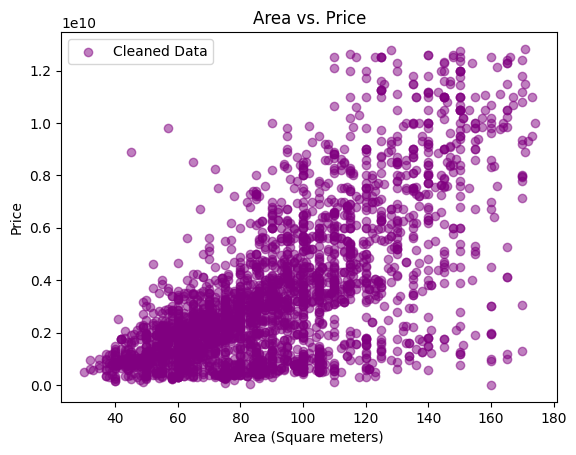

In [6]:
plt.scatter(cdf['Area'], cdf['Price'], color='purple', label='Cleaned Data', alpha=0.5)

# Add labels and title
plt.xlabel('Area (Square meters)')
plt.ylabel('Price')
plt.title('Area vs. Price')

# Add a legend
plt.legend()

plt.show()

### One Hot Encoding Address

In [7]:
print('Unique Adresses count is: ', len(cdf['Address'].unique()))
cdf['Address'].unique()

Unique Adresses count is:  187


array(['Shahran', 'Pardis', 'Shahrake Qods', 'Shahrake Gharb',
       'North Program Organization', 'Andisheh', 'West Ferdows Boulevard',
       'Narmak', 'Saadat Abad', 'Zafar', 'Islamshahr', 'Pirouzi',
       'Shahrake Shahid Bagheri', 'Moniriyeh', 'Amirieh',
       'Southern Janatabad', 'Salsabil', 'Zargandeh', 'Feiz Garden',
       'Water Organization', 'ShahrAra', 'Gisha', 'Ray', 'Abbasabad',
       'Ostad Moein', 'Farmanieh', 'Parand', 'Punak', 'Qasr-od-Dasht',
       'Aqdasieh', 'Railway', 'Central Janatabad',
       'East Ferdows Boulevard', 'Pakdasht KhatunAbad', 'Sattarkhan',
       'Shahryar', 'Northern Janatabad', 'Daryan No',
       'Southern Program Organization', 'Rudhen', 'West Pars', 'Afsarieh',
       'Marzdaran', 'Sadeghieh', 'Chahardangeh', 'Pakdasht', 'Baqershahr',
       'Jeyhoon', 'Lavizan', 'Shams Abad', 'Fatemi',
       'Keshavarz Boulevard', 'Baghestan', 'Kahrizak', 'Qarchak',
       'Northren Jamalzadeh', 'Azarbaijan', 'Bahar',
       'Persian Gulf Martyrs La

In [8]:
location_rank = [
    # Rank 0: Peripheral towns around Tehran
    ['Baghestan', 'Baqershahr', 'West Pars', 'Rudhen', 'Daryan No', 'Pakdasht KhatunAbad',
     'Water Organization', 'Sheikh Bahaei', 'Araj', 'Pardis', 'Davoodiyeh', 'Islamshahr',
     'Parand', 'Moghaddas Ardebili', 'Zargandeh', 'Nasim Shahr','Tenant','Chardangeh','Malard',
     'SabaShahr','Salehabad','Pishva','Islamshahr Elahieh','Firoozkooh Kuhsar','Shahedshahr',
     'Kazemabad','Robat Karim','Safadasht','Khademabad Garden','Hassan Abad','Thirteen November',
     'Alborz Complex','Firoozkooh','Vahidiyeh', 'Azadshahr', 'Waterfall'],
    
    # Rank 1: High-end and affluent areas
    ['Sohanak', 'Velenjak', 'Kamranieh', 'Darabad', 'Mahmoudieh',
     'Darakeh', 'Hekmat', 'Ekhtiarieh', 'Qalandari', 'Gheitarieh',
     'Farmanieh', 'Elahieh', 'Niavaran', 'Jamaran', 'Zaferanieh', 'Tajrish', 
     'Kashanak', 'Darband', 'Velanjak', 'Chizar', 'Kameranieh', 'Dezashib', 'Ajudaniye'],

    # Rank 2: Upscale neighborhoods with modern developments
    ['Shahrakeh Naft','Shahrake Azadi','Shahrake Apadana','Tarasht',
     'Sattarkhan', 'Saadat Abad', 'Shahrake Qods', 'Shahrake Gharb', 'ShahrAra', 'Gisha', 
     'Marzdaran', 'Punak', 'Farahzad', 'Azadi Square', 'Tehran Villa'],

    # Rank 3: Residential and business districts
    ['Seyed Khandan', 'Mirza Shirazi', 'Northern Suhrawardi',
     'Southern Suhrawardi', 'Garden of Saba''Gholhak', 'Shahrak-e Homayoun',
     'Zafar', 'Vanak', 'Dorous', 'Pasdaran', 'Mirdamad', 'Jordan', 'Telecommunication'],

    # Rank 4: Peaceful residential areas with greenery
    ['Hakimiyeh', 'East Pars', 'Heravi', 'Elm-o-Sanat', 'East Ferdows Boulevard',
     'Mehran', 'Lavizan', 'Hervi', 'Narmak South', 'Majidieh'],

    # Rank 5: Modern family-friendly neighborhoods
    ['Northern Chitgar', 'Southern Chitgar', 'Tehransar', 'Chardivari',
     'Shahr-e-Ziba', 'Northern Janatabad', 'Central Janatabad', 'Ekbatan',
     'Shahran', 'North Program Organization', 'Andisheh', 'West Ferdows Boulevard', 
     'Koohsar', 'Feiz Garden', 'Southern Program Organization',
     'Southern Janatabad', 'Chidz'],

    # Rank 6: Central neighborhoods with cultural and business landmarks
    ['Amirabad', 'Yousef Abad', 'Ghoba', 'Northren Jamalzadeh', 'Keshavarz Boulevard',
     'Abbasabad', 'Valiasr', 'Karimkhan', 'Fatemi', 'Yusef Abad', 'Komeil', 
     'Sanaei', 'Shiraz Boulevard', 'Shariati', 'Park Laleh', 'Argentina Square'],

    # Rank 7: Older central neighborhoods with historic significance
    ['Kook', 'Nezamabad', 'Garden of Saba', 'Bahar', 'Haft Tir', 'Motahari',
     'Sohrevardi', 'Heshmatieh', 'Shahid Ghandi', 'Sabalan', 'Nezam Abad',
     'Majidiyeh', 'Si Metri Ji'],

    # Rank 8: Dense but lively areas
    ['Narmak', 'Tehran Pars', 'Fadak', 'Dardasht', 'Taslihat'],

    # Rank 9: Industrial and transportation hubs
    ['Ozgol', 'Ostad Moein', 'Mehrabad', 'Mehrabad River River', 'Shadabad'],

    # Rank 10: Working-class areas with dense housing
    ['Karoon', 'Vahidieh', 'Hashemi', 'Jeyhoon', 'Shahryar', 'Salsabil', 'Karoun', 'Rudaki', 
     'Qasr-od-Dasht', 'Beryanak', 'Jeyhoun', 'Zanjan', 'Eskandari'],

    # Rank 11: Older districts with historical roots
    ['Nawab', 'Hor Square', 'Amir Bahador', 'Razi',
     'Republic', 'Azarbaijan', 'Railway', 'Moniriyeh', 'Shahrake Rah Ahan',
     'Amirieh', 'Sheikh Hadi', 'Enghelab', 'Hasan Abad'],

    # Rank 12: Religious and historical district
    ['Shoosh', 'Azari', 'Ray', 'Pamenar', 'Emamzadeh Yahya', 'Molavi',
     'Shahr-e Rey', 'Baharestan'],

    # Rank 13: Dense residential areas with modern improvements
    ['Ahang', 'Damavand', 'Pirouzi', 'Tehran Nou', 'Air force'],

    # Rank 14: Compact and densely populated areas
    ['Parastar', 'Abazar', 'Mahallati', 'Khavaran', 'Tehran Now'],

    # Rank 15: Upscale western neighborhoods
    ['Afsarieh', 'Shush', 'Ghiyamdasht', 'Atabak', 'Eram'],

    # Rank 16: Working-class southern districts
    ['Javadiyeh', 'Aliabad South', 'Naziabad', 'Yakhchiabad', 'Aliabad'],

    # Rank 17: Lower-income areas with dense housing
    ['Fallah', 'Qazvin Imamzadeh Hassan', 'Abuzar', 'Boloorsazi', 'Yaftabad', 'Imamzadeh Hassan'],

    # Rank 18: Suburban neighborhoods outside central Tehran
    ['Shadabad', 'Qarchak', 'Shams Abad', 'Chahardangeh', 'Sadeghieh'],

    # Rank 19: Less developed districts
    ['Resalat', 'Shahrake Madaen'],

    # Rank 20: Suburban areas with emerging development
    ['Ray - Montazeri', 'Ray - Pilgosh', 'Aqdasieh', 'Dolatabad', 'Kahrizak'],

    # Rank 21: Western neighborhoods and landmarks
    ['Shahrak 22 Bahman', 'Golestan', 'Shahrake Quds'],

    # Rank 22: Outskirts and less populated areas
    ['Persian Gulf Martyrs Lake', 'Dehkade Olampic', 'Zibadasht', 'Chitgar Lake', 'Shahrake Shahid Bagheri',
     'Northern Chitgar', 'Southern Chitgar']
]


In [9]:
# Create a mapping of areas to ranks
area_to_rank = {area: rank for rank, areas in enumerate(location_rank) for area in areas}

# Add the rank to the DataFrame based on the Address column
cdf['Area Rank'] = cdf['Address'].map(area_to_rank)
cdf.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),Area Rank
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67,5.0
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67,5.0
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33,0.0
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33,2.0
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33,2.0


In [10]:
cdf_dummies = pd.get_dummies(cdf['Area Rank'])
cdf_dummies

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3475,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3476,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3477,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
cdf = pd.concat([cdf, cdf_dummies], axis=1)
cdf

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),Area Rank,0.0,...,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67,5.0,False,...,False,False,False,False,False,False,False,False,False,False
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67,5.0,False,...,False,False,False,False,False,False,False,False,False,False
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33,0.0,True,...,False,False,False,False,False,False,False,False,False,False
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33,2.0,False,...,False,False,False,False,False,False,False,False,False,False
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33,2.0,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3.500000e+09,116666.67,5.0,False,...,False,False,False,False,False,False,False,False,False,False
3475,83,2,True,True,True,Niavaran,6.800000e+09,226666.67,1.0,False,...,False,False,False,False,False,False,False,False,False,False
3476,75,2,False,False,False,Parand,3.650000e+08,12166.67,0.0,True,...,False,False,False,False,False,False,False,False,False,False
3477,105,2,True,True,True,Dorous,5.600000e+09,186666.67,3.0,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
cdf.isna().sum()

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address        0
Price          0
Price(USD)     0
Area Rank     35
0.0            0
1.0            0
2.0            0
3.0            0
4.0            0
5.0            0
6.0            0
7.0            0
8.0            0
9.0            0
10.0           0
11.0           0
12.0           0
13.0           0
14.0           0
15.0           0
16.0           0
17.0           0
18.0           0
19.0           0
20.0           0
21.0           0
22.0           0
dtype: int64

In [13]:
cdf.dropna(inplace=True)

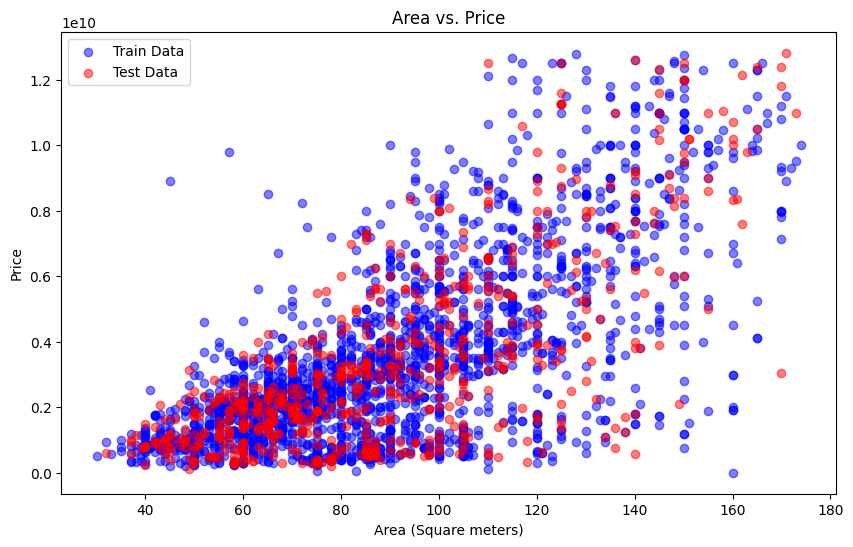

In [14]:
msk = np.random.rand(len(cdf)) < 0.80
train = cdf[msk]
test = cdf[~msk]

plt.figure(figsize=(10,6))  # Adjust the figure size for better visibility
plt.scatter(train['Area'], train['Price'], color='blue', label='Train Data', alpha=0.5)
plt.scatter(test['Area'], test['Price'], color='red', label='Test Data', alpha=0.5)


# Add labels and title
plt.xlabel('Area (Square meters)')
plt.ylabel('Price')
plt.title('Area vs. Price')

# Add a legend to differentiate between the datasets
plt.legend()

plt.show()

In [15]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
x_train = np.asanyarray(train.drop(['Price', 'Address', 'Price(USD)'], axis=1))
y_train = np.asanyarray(train[['Price']])

regr.fit (x_train, y_train)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

Coefficients:  [[ 5.31527184e+07 -2.09554788e+08  2.95654250e+08 -9.44650551e+07
   1.82887781e+08 -1.33970830e+08 -3.24467523e+09  2.52078419e+09
   1.61994633e+08  1.76927438e+09  1.60947257e+07 -4.18151548e+08
   5.75618909e+08 -8.65814546e+08  1.49132474e+08 -4.67521823e+08
  -2.73633094e+08 -3.25958732e+08 -8.22816854e+08  1.59522715e+08
   1.54034328e+09 -4.44244104e+08  5.70280675e+08  8.14717886e+07
   2.22860955e+08 -2.03884408e+09  1.23531314e+09 -3.15643151e+08
   2.14611301e+08]]
Intercept:  [-2.68018409e+08]


In [16]:
# Prepare testing data
x_test = np.asanyarray(test.drop(['Price', 'Address', 'Price(USD)'], axis=1))
y_test = np.asanyarray(test[['Price']])

# Make predictions
y_hat = regr.predict(x_test)

# Calculate and print the explained variance score
print('Variance score: %.2f' % regr.score(x_test, y_test))

Variance score: 0.76
